In [1]:
import pandas as pd     # 数据表
import numpy as np     # 数组
import re     # 正则表达式
import jieba     # 中文分词
import matplotlib.pyplot as plt     # 画图
from gensim.models import Word2Vec     # 训练词嵌入模型
# import gensim.downloader as api     # 导入云端的已训练好的词向量
from gensim.models import KeyedVectors     # 加载自己本地个性化的已训练好的词向量
from sklearn.metrics.pairwise import cosine_similarity     # 计算向量之间的余弦相似度
from sklearn.decomposition import PCA     # 语义空间降维，用于展示词语在二维空间的相对位置

In [158]:
df = pd.read_excel('weibo_sample.xlsx', index_col = 0)
df

,index,标题/微博内容,点赞,转发,评论,账号昵称UID加密,粉丝数,关注数,地域
0,34121,国债：地产行业重磅利好提振风险偏好，期债低开低走 国债期货全线收跌，10年期主力...,0,0,0,e5df796860e68f403bcf9651bab4d42e,0,0,其他
1,40230,#喜迎二十大 忠诚保平安#,0,0,0,6e35cb69ad52f20de5e28197b2e85306,405444,252,广西
2,7714,注意！事关明日教资考试！福建省教育考试院发布补充公告 福建省2022年下半年全国中小学教师...,0,0,0,e6953217442e6c06a7af23eee5e185f2,53264,2177,福建
3,27378,近日，“千年大计”雄安新区迎来五周岁生日。从“一张白纸...,0,0,0,NaN,0,0,北京
4,15435,樊振东牛逼！,0,0,0,344af41eac516375c04dee6325e763cc,8,51,山东
...,...,...,...,...,...,...,...,...,...
95,14034,老公好漂亮[舔屏],0,0,0,aa7af97ae98cbe8983e559b948ecfabf,825,191,北京
96,35249,恭喜@张小娜呀娜 1名用户获得【小飞T】。C官方唯一抽奖工具@C抽奖平台 对本次抽奖进行监督...,0,0,2,f538513e5801c275cbcf285517a8ee62,51709,20,北京
97,39598,接不动了，居民部门负债率提升空间太有限了。现在动辄几万一平米，总价高，月供高，预期转差，还怎...,0,0,0,2e76c39b6665a0b6f5bdc4c35f36f573,0,59,四川
98,48977,目前电子烟政策已从制定阶段逐渐走向实施阶段，而主要的电子烟公司股价下跌幅度高达70%-...,0,0,0,NaN,0,0,北京


## 语料预处理

### 剔除符号与数字

In [159]:
def remove_nums(text):
    nonums = re.sub('[^\u4e00-\u9fa5]+', '', text)
    return nonums
test = df['标题/微博内容'][8]
remove_nums(test)

'笑死我了我怎么才看到这条啊哈哈哈哈哈哈哈哈哈哈哈许昕在这个团队里要找你半天你在德国队那多显眼啊'

### 分词

In [160]:
# 加载中文停用词词典，可个性化设置
stopwords = open('stopwords.txt', encoding = 'utf-8').read()

def clean_text(text):
    words = jieba.lcut(text)
    words = [w for w in words if w not in stopwords]
    return ' '.join(words)
test = df['标题/微博内容'][8]
clean_text(test)

'笑 死 这条 哈哈哈哈 哈哈哈哈 哈哈哈 [ doge ] [ doge ] [ doge ] @ 许昕 团队 找 半天 德国队 那多 显眼 [ doge ]'

### 预处理

In [162]:
df['微博内容分词'] = df['标题/微博内容'].apply(remove_nums)
df['微博内容分词'] = df['微博内容分词'].apply(clean_text)
df.head()

,index,标题/微博内容,点赞,转发,评论,账号昵称UID加密,粉丝数,关注数,地域,微博内容分词
0,34121,国债：地产行业重磅利好提振风险偏好，期债低开低走 国债期货全线收跌，10年期主力...,0,0,0,e5df796860e68f403bcf9651bab4d42e,0,0,其他,国债 地产 行业 重磅 利好 提振 风险 偏好 期债 低开 低 走 国债 期货 全线 收跌 ...
1,40230,#喜迎二十大 忠诚保平安#,0,0,0,6e35cb69ad52f20de5e28197b2e85306,405444,252,广西,喜迎 二十大 忠诚 保平安
2,7714,注意！事关明日教资考试！福建省教育考试院发布补充公告 福建省2022年下半年全国中小学教师...,0,0,0,e6953217442e6c06a7af23eee5e185f2,53264,2177,福建,事关 明日 教资 考试 福建省 教育 考试院 发布 补充 公告 福建省 下半年 全国 中小学...
3,27378,近日，“千年大计”雄安新区迎来五周岁生日。从“一张白纸...,0,0,0,NaN,0,0,北京,近日 千年 大计 雄安 新区 迎来 五周岁 生日 一张白纸 塔吊 林立 雄安 新区 地上 地...
4,15435,樊振东牛逼！,0,0,0,344af41eac516375c04dee6325e763cc,8,51,山东,樊振东 牛 逼


## 词嵌入

### 原理解读

词向量（Word Vectors）是将词语映射到向量空间，使其成为向量空间中的一个点。在这个空间中，语义上相似的单词在空间中的距离也相近。在这个向量空间中，每个词语都用一个向量表示，这个向量是多维的，并且每一维都是一个实数。这就是所谓“单个词语的词向量”。

使用词向量，我们可以进行各种文本分析任务，如文本分类、情感分析、文本相似度计算等。通过计算两个词向量之间的余弦相似度，我们可以得到这两个词语在语义上的相似度。

### 使用词嵌入模型（给出3种方法）

#### 加载云端的预训练Word2Vec模型

In [163]:
# 云端下载需要联网，因而需要在网络连接畅通的环境下进行
# 另外，初次加载该模型可能会耗费一定时间，具体时间长短取决于网络连接状况

# 样例：
# w2v_model = api.load('word2vec-google-news-300')

#### 加载本地下载好的预训练Word2Vec模型

In [164]:
# 需要提前下载好，相当于一本词典，里面保存着各种词语的向量信息

# 样例：
weibo_model = KeyedVectors.load_word2vec_format('sgns.weibo.word', binary = False)

#### 自己训练Word2Vec模型

In [76]:
# corpus = df['微博内容分词'].apply(lambda x: x.split()).tolist()     # 切分词语
# model = Word2Vec(corpus,     # 喂词
#                  vector_size = 100,     # 自定义训练向量维度
#                  window = 5,     # 训练算法考虑的当前词语与预测词语在一个句子中的最大距离（窗口大小）
#                  min_count = 1,     # 忽略所有总频数低于这个值的词语
#                  workers = 4,     # 用于训练的线程数
#                  epochs = 100)     # 语料训练的迭代次数
# # 保存训练好的模型
# model.save('my_word2vec_model.model')

In [77]:
# vocab = model.wv.index_to_key  # 获取词汇表
# word_vectors = model.wv[vocab]  # 获取词向量

# # 打印词汇表和对应的词向量
# for word, vector in zip(vocab, word_vectors):
#     print(f'{word}: {vector}')

### 训练特定维度（幸福/不幸福）

In [165]:
# 正向词和负向词列表
positive_words = ['成功', '幸运', '快乐', '高兴', '愉悦', '微笑']
negative_words = ['失败', '不幸', '痛苦', '悲伤', '忧郁', '流泪']

# 获取“幸福/不幸福”维度向量
positive_vectors = np.array([weibo_model[word] for word in positive_words])
negative_vectors = np.array([weibo_model[word] for word in negative_words])
happiness_vector = np.mean(positive_vectors, axis=0) - np.mean(negative_vectors, axis = 0)

print('幸福向量：', happiness_vector)

幸福向量： [ 0.10031851  0.16376016  0.0334235   0.18151584 -0.24352665  0.21546832
  0.06015367 -0.12542969  0.10681649 -0.08369368 -0.00871766 -0.05614184
 -0.03825866  0.10680717  0.13791233 -0.35366586  0.1847575  -0.0185735
 -0.00251701 -0.02084017  0.25940815  0.05793548 -0.21013883 -0.19875082
  0.165512    0.18104699  0.08257233  0.19805464 -0.35812485  0.11933117
  0.09104836  0.1656775  -0.3641095  -0.071232    0.01360399 -0.11621899
  0.26765183  0.04917833  0.18571317  0.37504086  0.10311334 -0.00851701
  0.2820705  -0.3120655  -0.00646383  0.4650848  -0.00117902 -0.127843
 -0.21917117  0.00077617 -0.14472833 -0.29465982 -0.02702301  0.01346464
  0.07201399  0.20763999 -0.30559784  0.094543    0.30784598  0.28888518
 -0.01394486 -0.23813534  0.03716299 -0.32567182  0.08252317  0.16567868
 -0.0026965  -0.0458435   0.32676548  0.20562202 -0.06087117  0.20626117
  0.19393751 -0.3189785   0.10526666  0.26021418  0.08184482  0.02188718
  0.0738287  -0.14693482 -0.03155017 -0.04935749

### 个人语料在特定维度上的投射

In [166]:
df['微博内容分词列表'] = df['微博内容分词'].apply(lambda x: x.split())
df.head()

,index,标题/微博内容,点赞,转发,评论,账号昵称UID加密,粉丝数,关注数,地域,微博内容分词,微博内容分词列表
0,34121,国债：地产行业重磅利好提振风险偏好，期债低开低走 国债期货全线收跌，10年期主力...,0,0,0,e5df796860e68f403bcf9651bab4d42e,0,0,其他,国债 地产 行业 重磅 利好 提振 风险 偏好 期债 低开 低 走 国债 期货 全线 收跌 ...,"[国债, 地产, 行业, 重磅, 利好, 提振, 风险, 偏好, 期债, 低开, 低, 走,..."
1,40230,#喜迎二十大 忠诚保平安#,0,0,0,6e35cb69ad52f20de5e28197b2e85306,405444,252,广西,喜迎 二十大 忠诚 保平安,"[喜迎, 二十大, 忠诚, 保平安]"
2,7714,注意！事关明日教资考试！福建省教育考试院发布补充公告 福建省2022年下半年全国中小学教师...,0,0,0,e6953217442e6c06a7af23eee5e185f2,53264,2177,福建,事关 明日 教资 考试 福建省 教育 考试院 发布 补充 公告 福建省 下半年 全国 中小学...,"[事关, 明日, 教资, 考试, 福建省, 教育, 考试院, 发布, 补充, 公告, 福建省..."
3,27378,近日，“千年大计”雄安新区迎来五周岁生日。从“一张白纸...,0,0,0,NaN,0,0,北京,近日 千年 大计 雄安 新区 迎来 五周岁 生日 一张白纸 塔吊 林立 雄安 新区 地上 地...,"[近日, 千年, 大计, 雄安, 新区, 迎来, 五周岁, 生日, 一张白纸, 塔吊, 林立..."
4,15435,樊振东牛逼！,0,0,0,344af41eac516375c04dee6325e763cc,8,51,山东,樊振东 牛 逼,"[樊振东, 牛, 逼]"


In [167]:
def compute_similarity(word, happiness_vector, model):
    if word in model:
        word_vector = model[word]
        similarity = cosine_similarity([word_vector], [happiness_vector])
        return similarity[0][0]
    else:
        return None

In [168]:
# 计算每个词与“幸福/不幸福”维度的相似度，并存储结果
df['幸福相似度'] = df['微博内容分词'].apply(lambda x: [compute_similarity(word, happiness_vector, weibo_model) for word in x])

In [169]:
df['平均幸福度'] = df['幸福相似度'].apply(lambda x: np.mean([val for val in x if val is not None]))

E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [170]:
df.head()

,index,标题/微博内容,点赞,转发,评论,账号昵称UID加密,粉丝数,关注数,地域,微博内容分词,微博内容分词列表,幸福相似度,平均幸福度
0,34121,国债：地产行业重磅利好提振风险偏好，期债低开低走 国债期货全线收跌，10年期主力...,0,0,0,e5df796860e68f403bcf9651bab4d42e,0,0,其他,国债 地产 行业 重磅 利好 提振 风险 偏好 期债 低开 低 走 国债 期货 全线 收跌 ...,"[国债, 地产, 行业, 重磅, 利好, 提振, 风险, 偏好, 期债, 低开, 低, 走,...","[-0.013927069, -0.06980883, None, -0.039728444...",-0.009340
1,40230,#喜迎二十大 忠诚保平安#,0,0,0,6e35cb69ad52f20de5e28197b2e85306,405444,252,广西,喜迎 二十大 忠诚 保平安,"[喜迎, 二十大, 忠诚, 保平安]","[-0.07830257, 0.1258979, None, 0.028577918, 0....",0.016362
2,7714,注意！事关明日教资考试！福建省教育考试院发布补充公告 福建省2022年下半年全国中小学教师...,0,0,0,e6953217442e6c06a7af23eee5e185f2,53264,2177,福建,事关 明日 教资 考试 福建省 教育 考试院 发布 补充 公告 福建省 下半年 全国 中小学...,"[事关, 明日, 教资, 考试, 福建省, 教育, 考试院, 发布, 补充, 公告, 福建省...","[-0.04732964, -0.011227121, None, 0.003813445,...",-0.012029
3,27378,近日，“千年大计”雄安新区迎来五周岁生日。从“一张白纸...,0,0,0,NaN,0,0,北京,近日 千年 大计 雄安 新区 迎来 五周岁 生日 一张白纸 塔吊 林立 雄安 新区 地上 地...,"[近日, 千年, 大计, 雄安, 新区, 迎来, 五周岁, 生日, 一张白纸, 塔吊, 林立...","[0.051142078, 0.0319201, None, 0.0072106007, -...",0.004027
4,15435,樊振东牛逼！,0,0,0,344af41eac516375c04dee6325e763cc,8,51,山东,樊振东 牛 逼,"[樊振东, 牛, 逼]","[0.102939755, 0.041397326, 0.069922805, None, ...",0.019870


检查词嵌入模型中任意两个词向量的余弦相似度，即语义接近性。
余弦相似度的取值介于[-1, 1]之间，-1表示语义完全相反，1表示语义完全相同，0表示毫无关系；
model.sv.similarity这个函数与np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))的输出结果一致；

### 可视化

In [171]:
# 可视化
words = ['特价', '打折', '便宜', '礼品', '物美价廉', '实用']
vectors = [weibo_model[word] for word in words]

# 使用PCA进行降维
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(vectors)

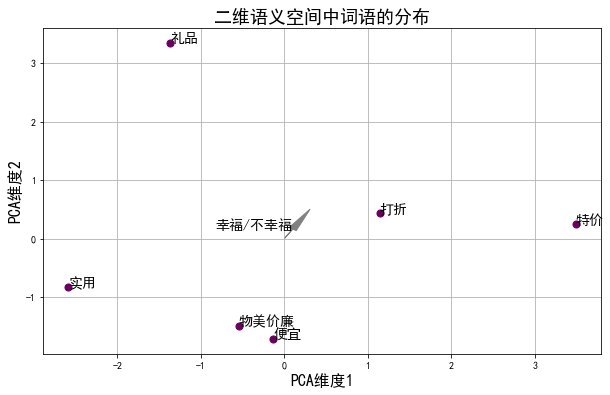

In [172]:
# 绘制四个词语在二维空间的相对位置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (10, 6))

# 画“幸福/不幸福”维度向量
plt.arrow(0, 0, happiness_vector[0], happiness_vector[1], color='grey', head_width=0.1, head_length=0.4)
plt.text(happiness_vector[0], happiness_vector[1], '幸福/不幸福', fontsize=14, ha='right', color='black')

# 取PCA降维结果中所有行的第一列和第二列数据绘制散点图，设置点的大小为50
plt.scatter(pca_result[:, 0], pca_result[:, 1], s = 50, color='#6a005f')

for i, word in enumerate(words):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]), fontsize=14)

plt.xlabel('PCA维度1', fontsize = 16)
plt.ylabel('PCA维度2', fontsize = 16)
plt.title('二维语义空间中词语的分布', fontsize = 18)
plt.grid(True)
plt.show()